In [1]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak

ROOT_DATA_DIR = "mu3e_root_data"
signal_data_file = f"{ROOT_DATA_DIR}/run42_sig.root"
background_data_file = f"{ROOT_DATA_DIR}/run42_bg.root"

with uproot.open(background_data_file) as file:
    bg_sensor_positions = file["alignment/sensors"].arrays(library="pd")
    bg_event_data = file["mu3e"].arrays(library="pd")
with uproot.open(signal_data_file) as file:
    sig_sensor_positions = file["alignment/sensors"].arrays(library="pd")
    sig_event_data = file["mu3e"].arrays(library="pd")

In [2]:
def load_ragged_csv_to_ndarray(file_name: str, delimiter: str = ",", fill_value = -1, max_cols = 256, dtype = int) -> np.ndarray:
    rows = []
    row_lengths = []
    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by the delimiter and strip whitespace
            row = np.array([value.strip() for value in line.strip().split(delimiter) if value != ''], dtype=dtype)
            # Ensure the row has at most max_cols elements
            if len(row) > max_cols:
                continue
            rows.append(row)
            row_lengths.append(len(row))
    # Convert the list of rows to a 2D NumPy array
    ragged_array = np.full((len(rows), max_cols), fill_value, dtype=dtype)
    for i, row in enumerate(rows):
        ragged_array[i, :len(row)] = row
    return ragged_array


import numpy as np

def reorder_nla(nla: np.ndarray, padding_value: int = -1) -> np.ndarray:
    """
    Reorders the NLA array to ensure that non-padded entries are at the beginning.
    Assumes padding is identifiable via `nla[:, :, 0] == padding_value`.
    """
    # Identify valid entries
    valid_mask = nla[:, :, 0] != padding_value

    # Compute number of valid entries per batch
    counts = valid_mask.sum(axis=1)

    # Flatten for easier fancy indexing
    B, N, D = nla.shape
    flat_nla = nla.reshape(B * N, D)
    flat_valid_mask = valid_mask.reshape(B * N)

    # Get indices of valid entries
    valid_indices = np.nonzero(flat_valid_mask)[0]

    # Allocate output
    reordered_nla = np.full_like(nla, padding_value)

    # Fill output using advanced indexing
    row_ids = np.repeat(np.arange(B), counts)
    group_counts = np.bincount(row_ids, minlength=B)

    # Compute start indices for placing data
    start_idx = np.zeros_like(group_counts)
    np.cumsum(group_counts[:-1], out=start_idx[1:])

    # Where to write valid entries in each row
    insert_pos = np.hstack([np.arange(c) for c in group_counts])
    reordered_nla[row_ids, insert_pos] = flat_nla[valid_indices]

    return reordered_nla



In [3]:
def load_ak_series_to_numpy(series: pd.Series, max_cols: int = 256, fill_value: int = -1) -> np.ndarray:
    """
    Converts an Awkward Array Series to a padded NumPy array (2D).
    Pads each row to `max_cols`, truncates longer rows, and ignores empty arrays.
    """
    # Combine series into one awkward array
    ak_array = ak.Array(series.to_list())  # safe if series contains ak Arrays or lists

    # Filter out arrays of invalid lengths
    lengths = ak.num(ak_array)
    mask = (lengths > 0) & (lengths <= max_cols)
    ak_array = ak_array[mask]

    # Clip longer arrays (optional depending on your needs)
    ak_array = ak.pad_none(ak_array, max_cols, clip=True)
    
    # Replace None with fill_value
    ak_array_filled = ak.fill_none(ak_array, fill_value)

    # Convert to NumPy
    result = ak.to_numpy(ak_array_filled)
    return result

In [54]:
def convert_pid_to_location(pixel_id: np.ndarray, sensor_positions: pd.DataFrame,
                                padding_value: float = -1, sensor_fault_rate=0.0) -> np.ndarray:
    if sensor_positions.empty:
        raise ValueError("sensor_positions DataFrame is empty.")
    
    required_columns = ["id", "vx", "vy", "vz", "rowx", "rowy", "rowz", "colx", "coly", "colz"]
    if not all(col in sensor_positions.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {required_columns}")
    
    # Preprocessing
    sensor_positions = sensor_positions.set_index("id", drop=False)
    valid_mask = pixel_id != padding_value

    # Decode pixel_id to chip, col, row
    hit_chip_id = (pixel_id // 2**16).astype(np.int32)
    hit_col_id = ((pixel_id // 2**8) % 2**8).astype(np.float32)
    hit_row_id = (pixel_id % 2**8).astype(np.float32)

    # Flatten inputs for easier indexing
    flat_valid_mask = valid_mask.flatten()
    flat_chip_id = hit_chip_id.flatten()
    flat_col_id = hit_col_id.flatten()
    flat_row_id = hit_row_id.flatten()


    keep_mask = (flat_chip_id // 2**12 == 0)

    # Apply sensor fault rate
    if sensor_fault_rate > 0:
        keep_mask = (np.random.rand(len(sensor_data)) >= sensor_fault_rate) & keep_mask

    flat_valid_mask = flat_valid_mask & keep_mask



    # Filter only valid pixel ids
    valid_chip_ids = flat_chip_id[flat_valid_mask]
    valid_cols = flat_col_id[flat_valid_mask] + 0.5
    valid_rows = flat_row_id[flat_valid_mask] + 0.5

    # Lookup transformation vectors
    try:
        sensor_data = sensor_positions.loc[valid_chip_ids]
    except KeyError:
        raise ValueError("Some chip IDs not found in sensor_positions.")


    # Compute positions
    vx = sensor_data["vx"].values
    vy = sensor_data["vy"].values
    vz = sensor_data["vz"].values
    rowx = sensor_data["rowx"].values
    rowy = sensor_data["rowy"].values
    rowz = sensor_data["rowz"].values
    colx = sensor_data["colx"].values
    coly = sensor_data["coly"].values
    colz = sensor_data["colz"].values

    x = vx + valid_cols * colx + valid_rows * rowx
    y = vy + valid_cols * coly + valid_rows * rowy
    z = vz + valid_cols * colz + valid_rows * rowz

    # Fill output array
    location = np.full((*pixel_id.shape, 3), padding_value, dtype=np.float64)
    flat_location = location.reshape(-1, 3)
    flat_location[flat_valid_mask] = np.stack([x, y, z], axis=1)

    return location
def compute_distance(data : np.ndarray, padding_value = -1) -> np.ndarray:
    distance_data = np.linalg.norm(data, axis = -1)
    distance_data[(data == padding_value).all(axis = -1)] = -1
    return distance_data
    

def sort_by_feature(data: np.ndarray, feature: np.ndarray, padding_value=-1) -> np.ndarray:
    """
    Vectorized version: Sorts `data` along axis 1 by `feature`, respecting a padding mask.
    """
    if data.shape[0:2] != feature.shape[0:2]:
        raise ValueError("Data and feature must have the same number of rows and columns.")

    # Create a valid mask over first 2 dims
    if data.ndim == 3:
        valid_mask = (data != padding_value).any(axis=-1)  # shape (B, N)
    elif data.ndim == 2:
        valid_mask = (data != padding_value)
    else:
        raise ValueError("Data must be 2D or 3D array.")

    # Number of valid elements per row
    num_valid = valid_mask.sum(axis=1)

    # argsort feature, ignoring invalid entries
    sort_indices = np.argsort(np.where(valid_mask, feature, np.inf), axis=1)

    # Prepare output filled with padding_value
    sorted_data = np.full_like(data, padding_value)

    # Use np.take_along_axis to reorder data
    if data.ndim == 3:
        sorted_full = np.take_along_axis(data, sort_indices[:, :, None], axis=1)
    elif data.ndim == 2:
        sorted_full = np.take_along_axis(data, sort_indices[:, :], axis=1)
    else:
        raise ValueError("Data must be 2D or 3D array.")

    # Mask out only the valid sorted parts
    for i, n_valid in enumerate(num_valid):
        if n_valid > 0:
            sorted_data[i, :n_valid] = sorted_full[i, :n_valid]

    return sorted_data


In [55]:
DATA_DIR = "mu3e_trigger_data"

bg_data = load_ak_series_to_numpy(bg_event_data["hit_pixelid"], max_cols=256, fill_value=-1)
sig_data = load_ak_series_to_numpy(sig_event_data["hit_pixelid"], max_cols=256, fill_value=-1)
bg_timestamps = load_ak_series_to_numpy(bg_event_data["hit_timestamp"], max_cols=256, fill_value=-1)
sig_timestamps = load_ak_series_to_numpy(sig_event_data["hit_timestamp"], max_cols=256, fill_value=-1)

In [56]:
bg_data_positions = convert_pid_to_location(bg_data, bg_sensor_positions, padding_value=-1)
sig_data_positions = convert_pid_to_location(sig_data, sig_sensor_positions, padding_value=-1)
bg_mask = (bg_data_positions != -1).all(axis=-1)
sig_mask = (sig_data_positions != -1).all(axis=-1)

In [57]:
time_sorted_bg_positions = sort_by_feature(bg_data_positions, bg_timestamps, padding_value=-1)
time_sorted_sig_positions = sort_by_feature(sig_data_positions, sig_timestamps, padding_value=-1)
time_sorted_bg_timestamps = sort_by_feature(bg_timestamps, bg_timestamps, padding_value=-1)
time_sorted_sig_timestamps = sort_by_feature(sig_timestamps, sig_timestamps, padding_value=-1)

In [58]:
bg_data_distances = compute_distance(bg_data_positions)
sig_data_distances = compute_distance(sig_data_positions)

In [59]:
(time_sorted_bg_positions[:1] != -1).all(axis = -1).sum(axis = -1), (time_sorted_bg_timestamps[:1] != -1).sum(axis = -1), 

(array([41]), array([51]))

/var/folders/_g/_c450dkj4j5djz911r45hnlc0000gn/T/ipykernel_7343/3732027873.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c="blue", cmap='viridis', marker='o')


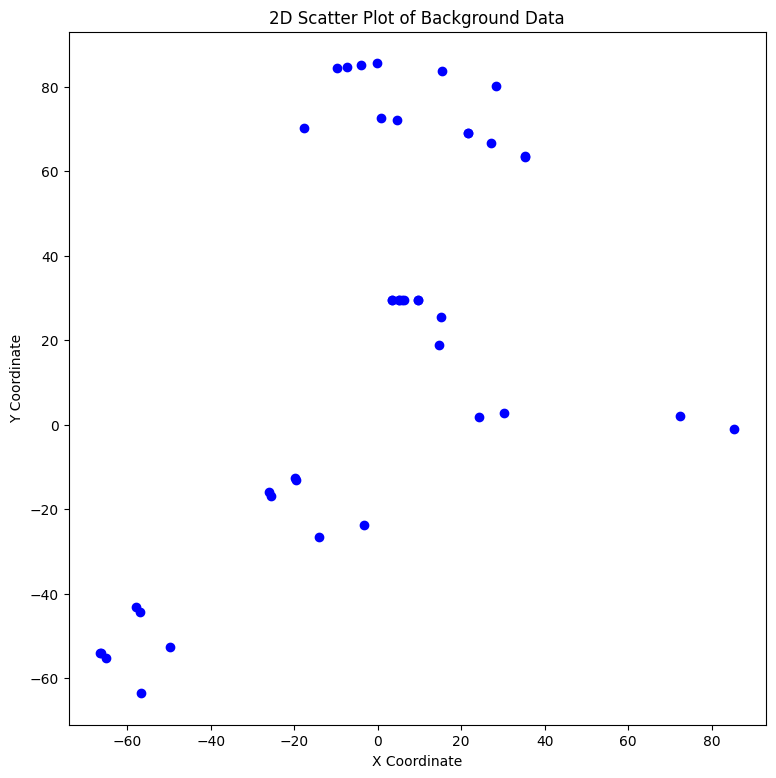

In [66]:
import matplotlib.pyplot as plt
x, y = bg_data_positions[:1, :, 0], bg_data_positions[:1, :, 1]
timestamps = bg_timestamps[:1, :]

x = x[x != -1]
y = y[y != -1]
timestamps = timestamps[timestamps != -1]
plt.figure(figsize=(9, 9))
plt.scatter(x, y, c="blue", cmap='viridis', marker='o')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("2D Scatter Plot of Background Data")
plt.show()

In [62]:
time_sorted_bg_positions = reorder_nla(time_sorted_bg_positions, padding_value=-1)
time_sorted_bg_positions = reorder_nla(time_sorted_bg_positions, padding_value=-1)

Text(0.5, 0.92, '3D Scatter Plot of Background Data')

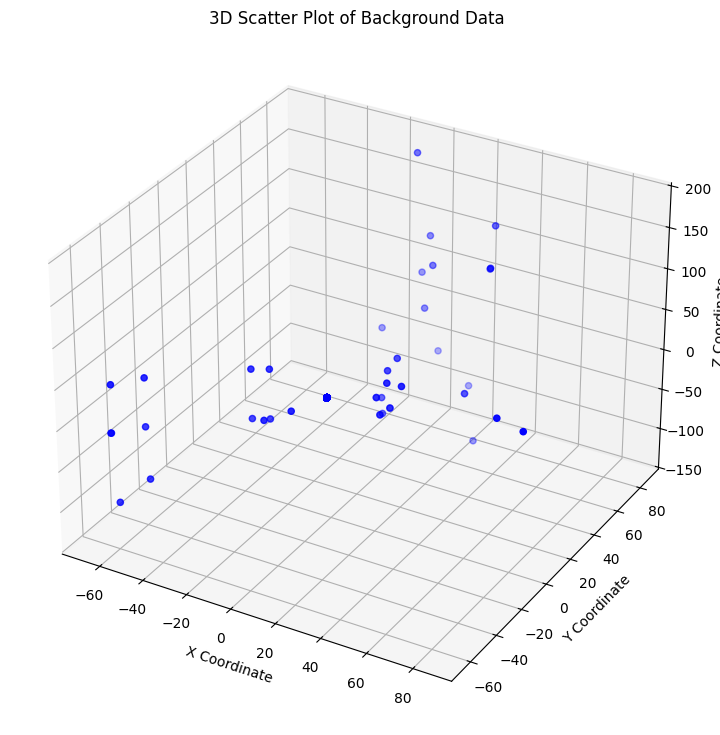

In [63]:
import matplotlib.pyplot as plt
x, y,z  = time_sorted_bg_positions[:1, :, 0], time_sorted_bg_positions[:1, :, 1], time_sorted_bg_positions[:1, :, 2]
plt.figure(figsize=(10, 9))
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c="blue", marker="o")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Scatter Plot of Background Data")

In [13]:
np.save(f"{DATA_DIR}/run42_bg_positions.npy", time_sorted_bg_positions)
np.save(f"{DATA_DIR}/run42_sig_positions.npy", time_sorted_bg_positions)

In [14]:
def convert_pixel_id_to_nla(pixel_id: np.ndarray, padding_value: int = -1) -> np.ndarray:
    nla = np.full((*pixel_id.shape, 4), padding_value, dtype=np.int32)
    valid_mask = pixel_id != padding_value

    chip_id = pixel_id // 2**16
    station = chip_id // 2**12
    layer = ((chip_id // 2**10) % 4) + 1
    phi = ((chip_id // 2**5) % 2**5) + 1
    z_prime = chip_id % 2**5

    z = np.where(layer == 3, z_prime - 7, np.where(layer == 4, z_prime - 6, z_prime))

    station_mask = (station == 0)
    valid_mask = valid_mask & station_mask

    nla[valid_mask, 0] = station[valid_mask]
    nla[valid_mask, 1] = layer[valid_mask]
    nla[valid_mask, 2] = phi[valid_mask]
    nla[valid_mask, 3] = z[valid_mask]

    return nla

def reorder_nla(nla: np.ndarray, padding_value: int = -1) -> np.ndarray:
    """
    Reorders the NLA array to ensure, that the non-padded entries are at the beginning of the array.
    """
    reordered_nla = np.full_like(nla, padding_value, dtype=nla.dtype)
    valid_mask = nla[:, :, 0] != padding_value
    for i in range(nla.shape[0]):
        valid_entries = nla[i, valid_mask[i]]
        if valid_entries.size > 0:
            reordered_nla[i, :valid_entries.shape[0]] = valid_entries

    return reordered_nla


def convert_nla_to_location(nla: np.ndarray, padding_value: float = -1) -> np.ndarray:
    location = np.full((*nla.shape[:-1], 3), padding_value, dtype=np.float64)
    layer = nla[:, : , 1]
    phi = nla[:, : , 2]
    z = nla[:, : , 3]
    #### Define the paramters of the detector layers
    r_layer_1 = 23.3
    r_layer_2 = 29.8
    r_layer_3 = 73.9
    r_layer_4 = 86.3
    length_layer_1 = 124.7
    length_layer_2 = 124.7
    length_layer_3 = 351.9
    length_layer_4 = 372.6
    nz_layer_1 = 6
    nz_layer_2 = 6
    nz_layer_3 = 17
    nz_layer_4 = 18

    nphi_layer_1 = 8
    nphi_layer_2 = 10
    nphi_layer_3 = 24
    nphi_layer_4 = 28

    #### Calculate the z-coordinate in the detector
    location[layer == 1, 2] = ((z[layer == 1])/ nz_layer_1 - 0.5 ) * length_layer_1
    location[layer == 2, 2] = ((z[layer == 2])/ nz_layer_2 - 0.5 ) * length_layer_2
    location[layer == 3, 2] = ((z[layer == 3])/ nz_layer_3 - 0.5 ) * length_layer_3
    location[layer == 4, 2] = ((z[layer == 4])/ nz_layer_4 - 0.5 ) * length_layer_4

    #### Calculate the x-coordinate in the detector
    location[layer == 1, 0] = r_layer_1 * np.cos((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 0] = r_layer_2 * np.cos((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 0] = r_layer_3 * np.cos((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 0] = r_layer_4 * np.cos((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    #### Calculate the y-coordinate in the detector
    location[layer == 1, 1] = r_layer_1 * np.sin((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 1] = r_layer_2 * np.sin((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 1] = r_layer_3 * np.sin((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 1] = r_layer_4 * np.sin((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    return location


def load_ragged_csv_to_ndarray(file_name: str, delimiter: str = ",", fill_value = -1, max_cols = 256, dtype = int) -> np.ndarray:
    rows = []
    row_lengths = []
    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by the delimiter and strip whitespace
            row = np.array([value.strip() for value in line.strip().split(delimiter) if value != ''], dtype=dtype)
            # Ensure the row has at most max_cols elements
            if len(row) > max_cols:
                continue
            rows.append(row)
            row_lengths.append(len(row))
    # Convert the list of rows to a 2D NumPy array
    ragged_array = np.full((len(rows), max_cols), fill_value, dtype=dtype)
    for i, row in enumerate(rows):
        ragged_array[i, :len(row)] = row
    return ragged_array

